# Local, Regional, and Global Moran's I and Geary's C spatial statistics.
### This notebook walks you through how to calculate spatial statistic for raster datasets using Raster Tools and use those statistics to determine a kernel size that accounts for spatial correlation.

John Hogland 2/11/2025

## Install necessary packages to run on Colab

In [ ]:
!pip install mapclassify
!pip install osmnx
!pip install raster_tools
!pip install planetary-computer
!pip install pystac-client
!pip install stackstac


## Import packages

In [7]:
import numpy as np, os, geopandas as gpd, numba as nb, osmnx as ox, pystac_client, planetary_computer, stackstac
from raster_tools import raster, Raster, focal

### The study area
#### Get the boundary data for portions of the Custer Gallatin National Forest and create a interactive location map of the study (Figure 1).

In [2]:
import folium
#use OpenStreetMaps to get the boundary of the NF
nf=ox.geocode_to_gdf('Custer Gallatin National Forest, MT, USA')

#get first polygon of the NF
nfe=nf.explode()
nf1=gpd.GeoSeries(nfe.geometry.iloc[10],crs=nf.crs)

#project to Albers equal area
nf1p=nf1.to_crs(5070)

#Visualize the nf1 and sample locations
m=nf1p.explore(color='red',style_kwds=dict(fill=False,weight=5),name='Boundary')
folium.TileLayer(
    tiles="https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}",
    attr="Esri",
    name="Esri Imagery",
    overlay=False,
    control=True,
).add_to(m)
folium.LayerControl().add_to(m)
m

C:\Users\jshogland\AppData\Local\Temp\ipykernel_8336\1171526418.py:6: FutureWarning: Currently, index_parts defaults to True, but in the future, it will default to False to be consistent with Pandas. Use `index_parts=True` to keep the current behavior and True/False to silence the warning.
  nfe=nf.explode()


__Figure 1.__ Interactive location map of the study area.

### Step 1: Get Landsat 8 Imagery
Create download definitions

In [3]:
#create definition to mosaic stac data
def mosaic_stac(xr):
    return stackstac.mosaic(xr)

#create definition to extract stac data
def get_stac_data(geo,url="https://planetarycomputer.microsoft.com/api/stac/v1",name="sentinel-2-l2a",res=30,crs=5070,**kwarg):
    '''
    gets tiled data from planetary computer as a dask backed xarray that intersects the geometry of the point, line, or polygon

    geo = (polygon) geometry bounding box (WGS84)
    url = (string) base url to planetary computer https://planetarycomputer.microsoft.com/api/stac/v1
    name = (string) catelog resource
    qry =  (dictoinary) of property values {'eo:cloud_cover':{'lt':1}}
    res = (tuple of numbers) output resolution (x,y)
    crs = (int) output crs
    dt = (string) data time intervale e.g., one month: 2023-06, range: 2023-06-02/2023-06-17
    limit = (int) max number of items to return

    returns (xarray data array and stac item catalog)
    '''
    catalog = pystac_client.Client.open(url, modifier=planetary_computer.sign_inplace)
    srch = catalog.search(collections=name, intersects=geo, **kwarg)
    ic = srch.item_collection()
    if(len(ic.items)>0):
        xra = stackstac.stack(ic,resolution=res,epsg=crs)
        xra = mosaic_stac(xra)
    else:
        xra=None

    return xra,ic


Download the data and create a raster object

In [4]:
#get stac data landsat data
if(not os.path.exists('ls82016.tif')):
    xmin,ymin,xmax,ymax=nf1p.buffer(200).total_bounds
    ls30, ic =get_stac_data(nf1.geometry[0],"https://planetarycomputer.microsoft.com/api/stac/v1",name="landsat-c2-l2",res=30,crs=5070,datetime='2016-06-15/2016-06-30',query={'eo:cloud_cover':{'lt':10},'platform':{'eq':'landsat-8'}},limit=1000)
    ls30s=Raster(ls30.sel(band=['red', 'green', 'blue','nir08', 'lwir11','swir16', 'swir22'],x=slice(xmin,xmax),y=slice(ymax,ymin)))
    ls30s=ls30s.save('ls82016.tif')

ls30s=Raster('ls82016.tif')

Visualize the study area and the Landsat 8 image (Figure 2).

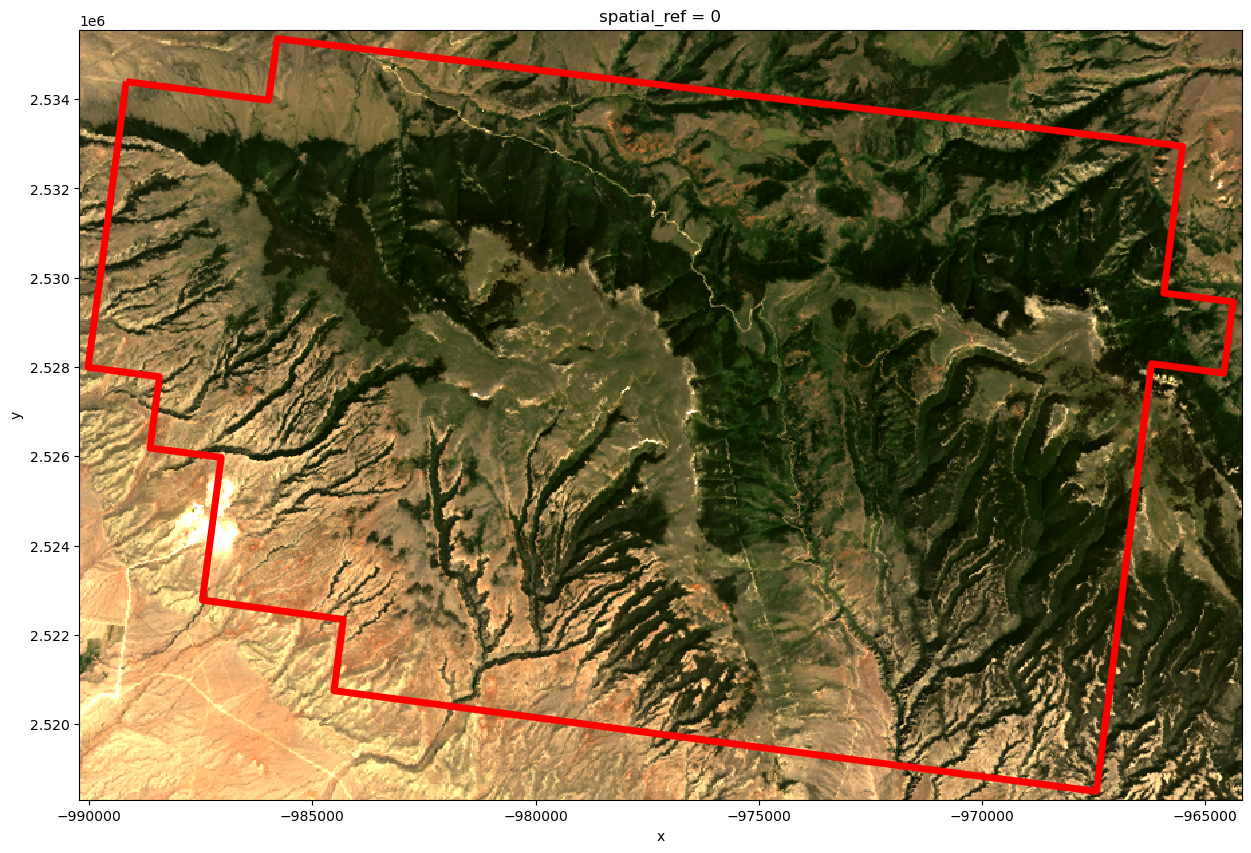

In [5]:
p=nf1p.plot(edgecolor='red',facecolor='none',figsize=(15,10),linewidth=5)
p=ls30s.get_bands([1,2,3]).xdata.plot.imshow(ax=p,robust=True)


### Step 2: Performing spatial statistics

#### Create definition from Moran's I and Geary's C.

In [8]:
# Spatial stats
@nb.jit(nopython=True, nogil=True)
def _get_l_morani(img,wm):
    '''
    calculates local Moran's I metric for a given array of values and weighted values. wm and img arrays must be the same size. 
    img=(2d numpy.array) of values e.g. [[1,2,3][4,5,6],[7,8,9]]
    wm=(2d numpy.array) of spatial weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]
    '''
    rws,clms=img.shape
    hr=int(rws/2)
    hc=int(clms/2)
    n=(rws*clms)
    s=0
    s2=0
    for r in range(rws):
        for c in range(clms):
            vl=img[r,c]
            s+=vl
            s2+=vl**2
    m=s/n
    v=(s2-((s**2)/n))/n
    i=img[hr,hc]
    s3=0
    for r in range(rws):
        for c in range(clms):
            vl=img[r,c]
            w=wm[r,c]
            s3+=w*(vl-m)
            
    return (((i-m)/v)*s3)/wm.sum()

@nb.jit(nopython=True, nogil=True)
def _get_l_gearyc(img,wm):
    '''
    calculates local Geary C metric for a given array of values and weighted values. wm and img arrays must be the same size. 
    img=(2d numpy.array) of values e.g. [[1,2,3][4,5,6],[7,8,9]]
    wm=(2d numpy.array) of spatial weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]

    '''
    rws,clms=img.shape
    hr=int(rws/2)
    hc=int(clms/2)
    n=(rws*clms)
    s=0
    s2=0
    s3=0
    i=img[hr,hc]
    for r in range(rws):
        for c in range(clms):
            vl=img[r,c]
            w=wm[r,c]
            s+=vl
            s2+=vl**2
            s3+=w*((vl-i)**2)

    v=(s2-((s**2)/(n)))/(n-1)         
    return (1/v)*s3

@nb.jit(nopython=True, nogil=True)
def _get_lisa(X,moran,wm):
    ''' 
    Creates local spatial statistic metrics
    
    X = (numpy.array) 3d array of numeric values
    moran = (boolean) if True (default), will return local Moran's I statistic. If False will return local Geary's C statistic
    wm = (numpy.array) 2d array of weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]
    
    returns ndarray of values
    '''
    bnds,rws,clms=X.shape
    wrws,wclms=wm.shape
    hwrws=int(wrws/2)
    hwclms=int(wclms/2)
    out_arr=np.zeros((bnds,rws,clms))
    for b in range(bnds):
        for r in range(rws-hwrws):
            nr=r+hwrws
            for c in range(clms-hwclms):
                nc=c+hwclms
                img=X[b,r:r+wrws,c:c+wclms]
                if(moran): vl = _get_l_morani(img,wm)
                else: vl= _get_l_gearyc(img,wm)
                out_arr[b,nr,nc]=vl
    return out_arr

def get_lisa(rs,moran=True,wm=np.array([[1,1,1],[1,0,1],[1,1,1]])):
    ''' 
    Creates local spatial statistic raster surface
    
    rs = (Raster) raster object of values
    moran = (boolean) if True (default), will return local Moran's I statistic. If False will return local Geary's C statistic
    wm = (numpy.array) 2d array of weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]
    
    returns raster
    '''
    #use map overlap function to retrieve kernel cell values
    r,c=wm.shape
    hr=int(r/2)
    hc=int(c/2)
    darr = rs.data.map_overlap(
        _get_lisa,
        depth={0: 0, 1: hr, 2: hc},
        trim=True,
        boundary=0,
        dtype='f8',
        meta=np.array((),dtype='f8'),
        moran=moran,
        wm=wm,
    )
    out_rs=raster.data_to_raster(darr,mask=rs.mask,x=rs.x,y=rs.y,affine=rs.affine,crs=rs.crs)
    return out_rs 

def get_risa(rs,moran=True,reg_ext=5,wm=np.array([[1,1,1],[1,0,1],[1,1,1]])):
    ''' 
    Creates Regional spatial statistic metrics for subregions within the raster based on the region extent of the analysis.
    Global spatial statistics are calculated for each subregion and applied to focal cell.
    
    rs = (Raster) raster object of values
    moran = (boolean) if True (default), will return Global Moran's I statistic. If False will return Global Geary's C statistic
    reg_ext= width of the region in pixels. A value of 1 will give the same result as LISA.
    wm = (numpy.array) 2d array of weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]
    
    returns a raster surface of Regional metrics for each cell within the defined region of the raster
    '''
    lrs=get_lisa(rs,moran,wm)
    if(moran):
        rrs= focal.focal(lrs,'mean',reg_ext,reg_ext)
    else:
        rrs= focal.focal(lrs,'sum',reg_ext,reg_ext)/(2*(reg_ext**2)*wm.sum())
    
    return rrs


def get_gisa(rs,moran=True,wm=np.array([[1,1,1],[1,0,1],[1,1,1]])):
    ''' 
    Creates Global spatial statistic metrics
    
    rs = (Raster) raster object of values
    moran = (boolean) if True (default), will return Global Moran's I statistic. If False will return Global Geary's C statistic
    wm = (numpy.array) 2d array of weights e.g. queen [[1,1,1][1,0,1],[1,1,1]] or rook [[0,1,0][1,0,1],[0,1,0]]
    
    returns the Global metric for all cells within the raster
    '''
    lrs=get_lisa(rs,moran,wm)
    s=lrs.sum()
    n=(~lrs.mask).sum()
    if(moran):
        ovl=s/n
    else:
        ovl=s/(2*n*wm.sum())
    return ovl


### Use local indicators of spatial association (LISA) and regional indicators of spatial association (RISA) definitions to determine a windows size that accounts for spatial correlation.

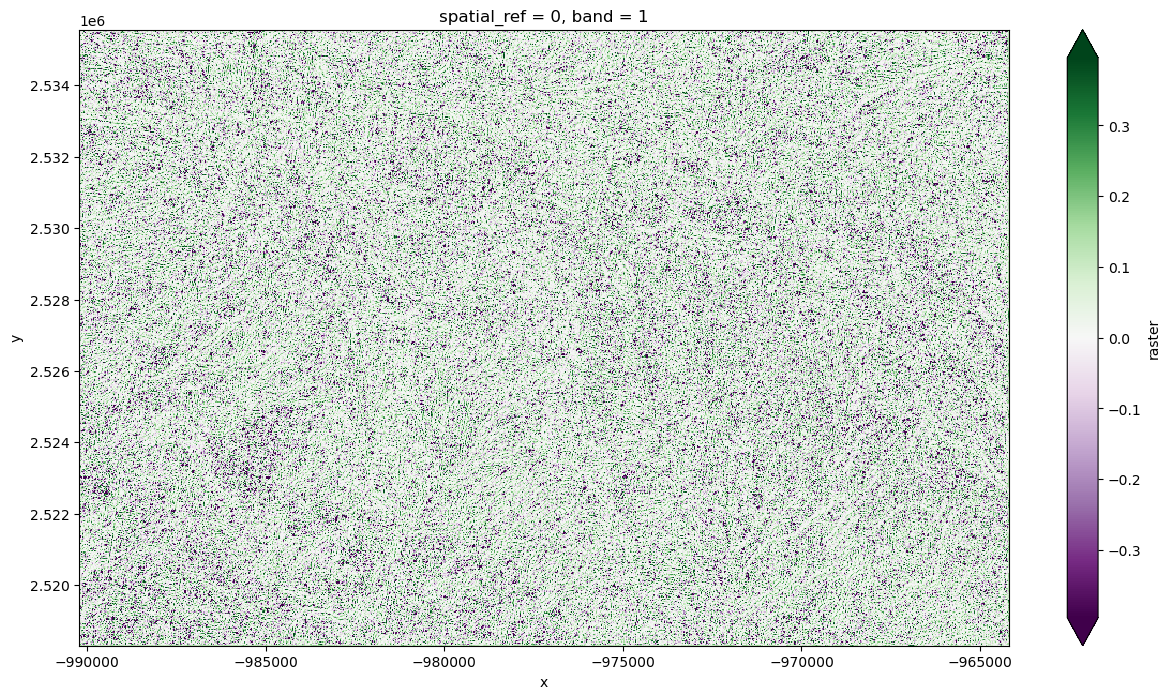

In [9]:
# Get Local Spatial Statistics
rs_lm=get_lisa(ls30s,True,np.array([[0,1,0],[1,0,1],[0,1,0]]))
rs_lm.get_bands(1).plot(figsize=(15,8),cmap='PRGn',robust=True)#x='x',y='y',col='band',col_wrap=3,figsize=(15,rs_lm.nbands),robust=True,cmap='PRGn')

In [10]:
# Get Regional Spatial Statistics
mlst=[]
slst=[]
wts = np.arange(1,53,2)
for w in wts:
    rs_rm=get_risa(ls30s,True,w,np.array([[0,1,0],[1,0,1],[0,1,0]]))
    b1=rs_rm.get_bands(1)
    mlst.append(b1.mean().compute())
    slst.append(b1.std().compute())

#b1.mean().plot(figsize=(15,8),cmap='PRGn',robust=True)#x='x',y='y',col='band',col_wrap=3,figsize=(15,rs_lm.nbands),robust=True,cmap='PRGn')

### Visualize the variation in RISA as window size increases.

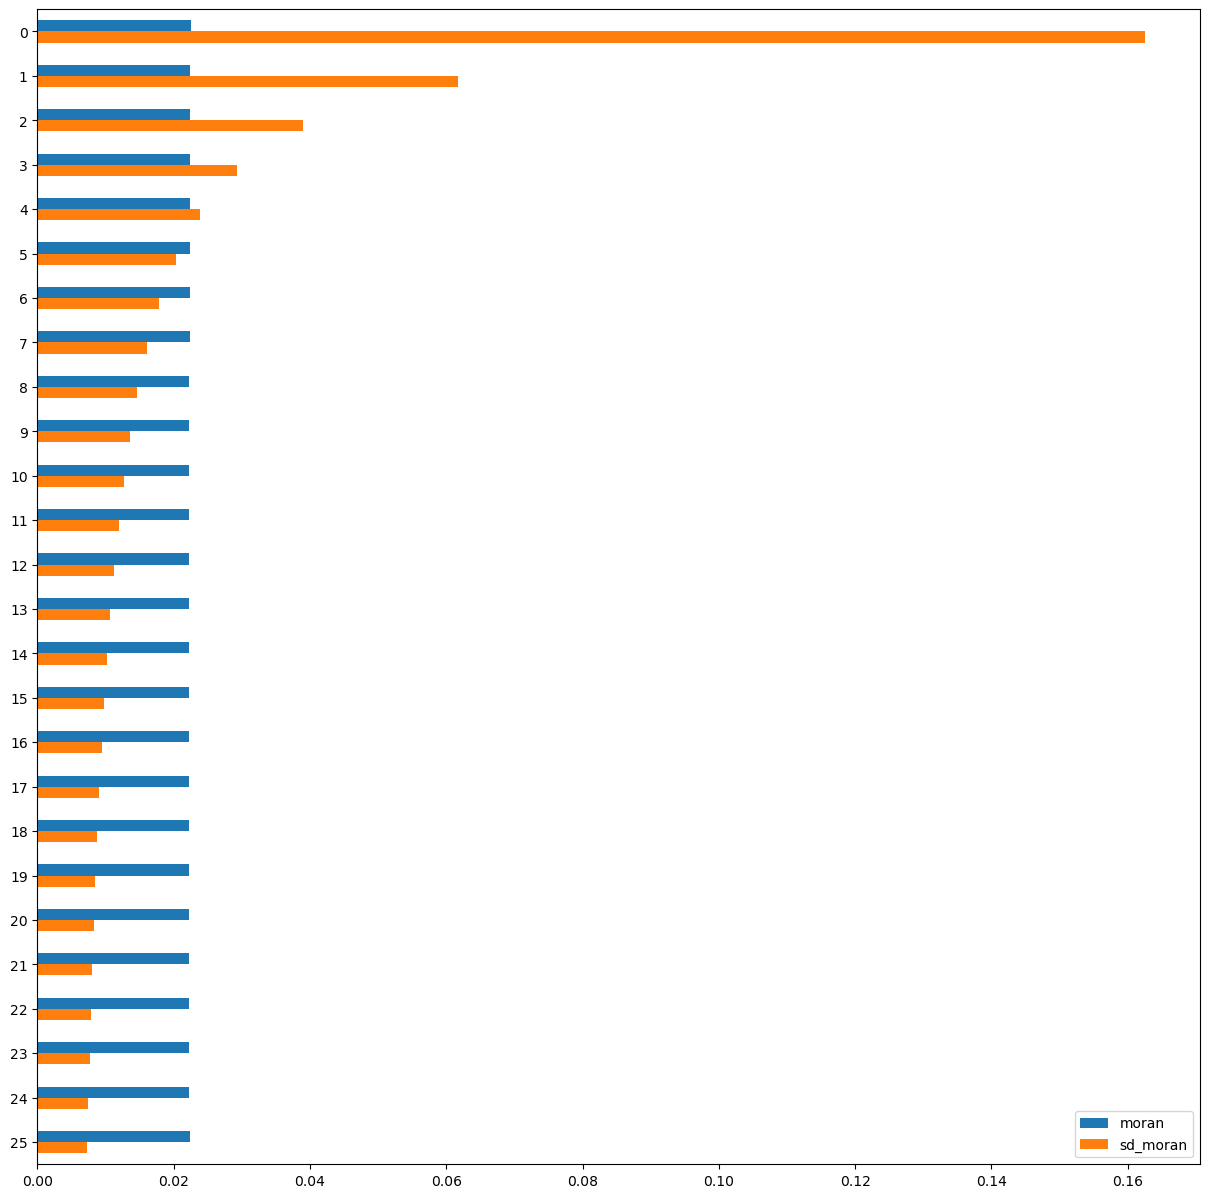

In [ ]:
#determine window size from change in regional moran's I
import pandas as pd
df=pd.DataFrame([wts,mlst,slst],index=['width','moran','sd_moran']).T
df[['moran','sd_moran']].plot(kind='barh',figsize=(15,15)).invert_yaxis()

              

## Discussion:
### A window size of 9 by 9 or 11 by 11 cells should be sufficiently large enough to account for spatial correlation. Note, how the mean of RISA metrics (i.e., global Moran's I, blue) remains constant while the standard deviation in RISA Moran's I decrease as window size increases. Interestingly, at the sixth iteration of RISA metrics for a 11 by 11 window, the standard deviation of RISA Moran I statistics begins to level off and drops below the Global Moran's I statistic. This point highlights the approximate size of a kernel or window needed to account for spatial correlation.                  